# Clustering en Datos Raw - DeepSolation

Este notebook aplica K-Means clustering a características estadísticas extraídas de las señales raw para evaluar si hay separación natural entre niveles de daño.

**Nota:** Ver `0_eda.ipynb` para el análisis exploratorio de datos.

In [3]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Agregar path de utilidades
sys.path.append('../utils')
from dataset_utils import load_raw_signals_dataset

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [12, 8]

print("Setup completado")

Setup completado


## 1. Carga de Datos

In [4]:
SIGNALS_DIR = "../../data/Signals_Raw/"
LABELS_CSV = "../../data/nivel_damage.csv"

print("Cargando datos raw...")
raw_dataset = load_raw_signals_dataset(SIGNALS_DIR, LABELS_CSV)

print(f"\nDataset cargado: {raw_dataset.shape}")
print(f"Columnas: {list(raw_dataset.columns)}")

Cargando datos raw...
✓ Cargadas etiquetas para 71 especímenes
✓ Encontradas 71 carpetas de especímenes
✓ Dataset creado: 11,992,212 filas
  Especímenes: 71

Dataset cargado: (11992212, 7)
Columnas: ['N_S', 'E_W', 'U_D', 'ID', 'sensor', 'tipo', 'nivel_damage']


## 2. Extracción de Características

Calculamos características estadísticas por espécimen y sensor.

In [5]:
def calculate_signal_features(group):
    """Calcula características estadísticas para un grupo de señales."""
    features = {}
    
    for axis in ['N_S', 'E_W', 'U_D']:
        signal = group[axis]
        features[f'{axis}_mean'] = signal.mean()
        features[f'{axis}_std'] = signal.std()
        features[f'{axis}_min'] = signal.min()
        features[f'{axis}_max'] = signal.max()
        features[f'{axis}_range'] = signal.max() - signal.min()
        features[f'{axis}_skew'] = signal.skew()
        features[f'{axis}_kurtosis'] = signal.kurtosis()
        features[f'{axis}_rms'] = np.sqrt(np.mean(signal**2))
        features[f'{axis}_q25'] = signal.quantile(0.25)
        features[f'{axis}_q75'] = signal.quantile(0.75)
    
    features['magnitude_mean'] = np.sqrt(group['N_S']**2 + group['E_W']**2 + group['U_D']**2).mean()
    features['magnitude_std'] = np.sqrt(group['N_S']**2 + group['E_W']**2 + group['U_D']**2).std()
    
    return pd.Series(features)

# Calcular features
print("Calculando características...")
features_df = raw_dataset.groupby(['ID', 'sensor']).apply(calculate_signal_features).reset_index()

# Agregar metadatos
metadata = raw_dataset.groupby(['ID', 'sensor'])[['tipo', 'nivel_damage']].first().reset_index()
features_df = features_df.merge(metadata, on=['ID', 'sensor'])

print(f"Features extraídas: {features_df.shape}")
print(f"Características por observación: {features_df.shape[1]-4}")

Calculando características...
Features extraídas: (142, 36)
Características por observación: 32


## 3. K-Means Clustering (k=3)

In [6]:
# Preparar datos
feature_cols = [col for col in features_df.columns if col not in ['ID', 'sensor', 'tipo', 'nivel_damage']]
X = features_df[feature_cols].copy()
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# Normalizar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)
features_df['cluster'] = cluster_labels

# Métricas
damage_mapping = {'N1': 0, 'N2': 1, 'N3': 2}
true_labels = features_df['nivel_damage'].map(damage_mapping)

print(f"K-Means Clustering (k=3):")
print(f"  Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.3f}")
print(f"  Adjusted Rand Index: {adjusted_rand_score(true_labels, cluster_labels):.3f}")
print(f"  Inercia: {kmeans.inertia_:.2f}")

K-Means Clustering (k=3):
  Silhouette Score: 0.826
  Adjusted Rand Index: 0.005
  Inercia: 1684.40


In [7]:
# Tabla cruzada
print("\nCluster vs Nivel de Daño:")
print(pd.crosstab(features_df['cluster'], features_df['nivel_damage'], margins=True))


Cluster vs Nivel de Daño:
nivel_damage   N1  N2  N3  All
cluster                       
0             102  29   8  139
1               0   1   0    1
2               2   0   0    2
All           104  30   8  142


## 4. Visualización con PCA y t-SNE

In [8]:
# Reducción de dimensionalidad
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)

print(f"PCA - Varianza explicada: {pca.explained_variance_ratio_.sum():.1%}")

PCA - Varianza explicada: 66.8%


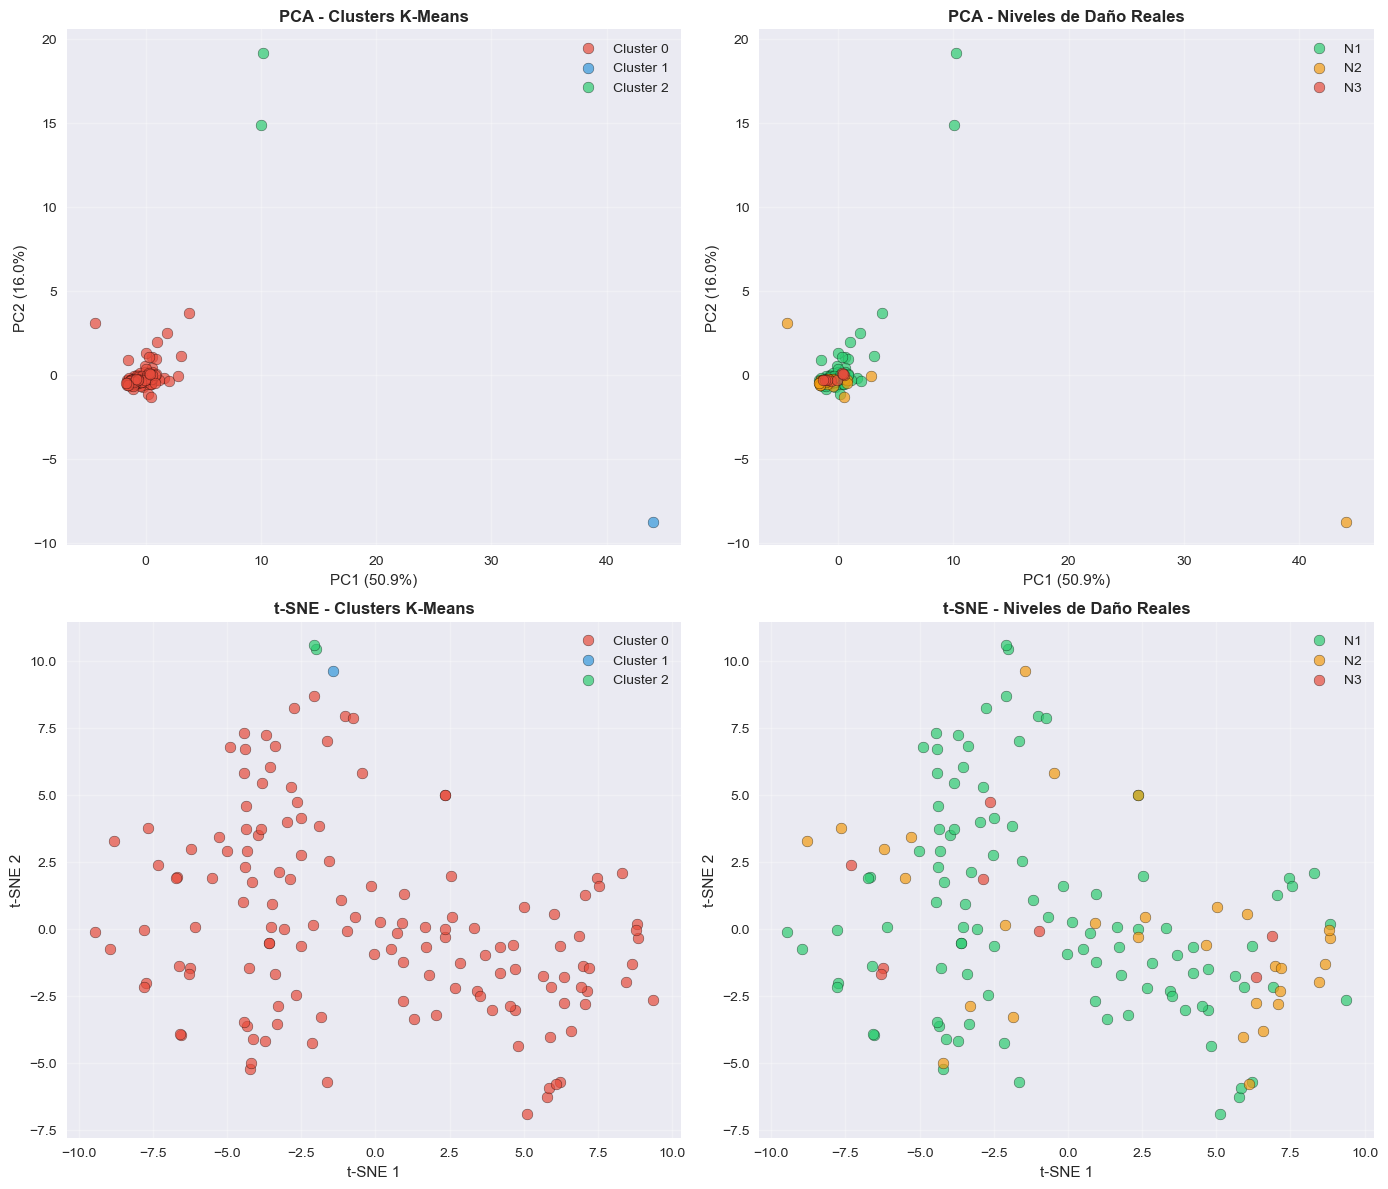

In [9]:
# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

cluster_colors = ['#e74c3c', '#3498db', '#2ecc71']
damage_colors = {'N1': '#2ecc71', 'N2': '#f39c12', 'N3': '#e74c3c'}

# PCA - Clusters
for i in range(3):
    mask = cluster_labels == i
    axes[0,0].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=cluster_colors[i], label=f'Cluster {i}', alpha=0.7, s=60, edgecolors='black')
axes[0,0].set_title('PCA - Clusters K-Means', fontweight='bold')
axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# PCA - Niveles reales
for nivel, color in damage_colors.items():
    mask = features_df['nivel_damage'] == nivel
    axes[0,1].scatter(X_pca[mask, 0], X_pca[mask, 1], 
                      c=color, label=nivel, alpha=0.7, s=60, edgecolors='black')
axes[0,1].set_title('PCA - Niveles de Daño Reales', fontweight='bold')
axes[0,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
axes[0,1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# t-SNE - Clusters
for i in range(3):
    mask = cluster_labels == i
    axes[1,0].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                      c=cluster_colors[i], label=f'Cluster {i}', alpha=0.7, s=60, edgecolors='black')
axes[1,0].set_title('t-SNE - Clusters K-Means', fontweight='bold')
axes[1,0].set_xlabel('t-SNE 1')
axes[1,0].set_ylabel('t-SNE 2')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# t-SNE - Niveles reales
for nivel, color in damage_colors.items():
    mask = features_df['nivel_damage'] == nivel
    axes[1,1].scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                      c=color, label=nivel, alpha=0.7, s=60, edgecolors='black')
axes[1,1].set_title('t-SNE - Niveles de Daño Reales', fontweight='bold')
axes[1,1].set_xlabel('t-SNE 1')
axes[1,1].set_ylabel('t-SNE 2')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Evaluación de Diferentes k

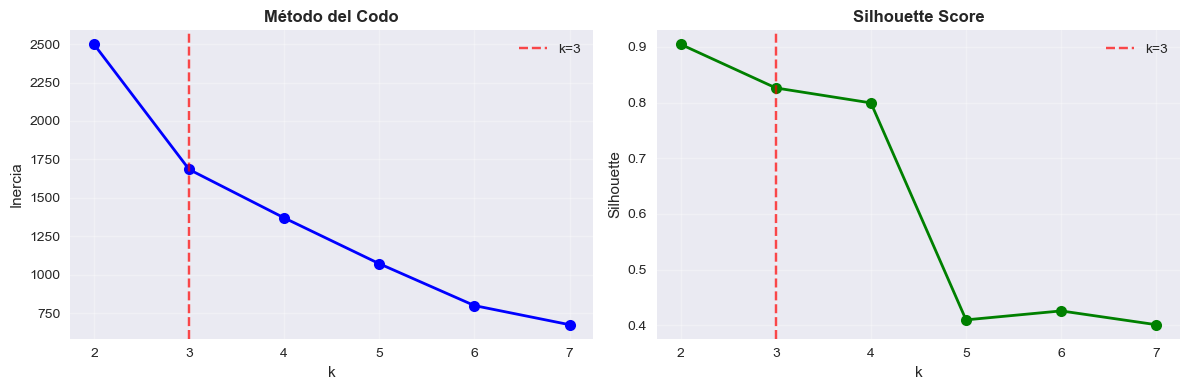

Mejor k según Silhouette: 2


In [10]:
k_range = range(2, 8)
inertias = []
silhouettes = []

for k in k_range:
    kmeans_k = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = kmeans_k.fit_predict(X_scaled)
    inertias.append(kmeans_k.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels_k))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].axvline(x=3, color='red', linestyle='--', alpha=0.7, label='k=3')
axes[0].set_title('Método del Codo', fontweight='bold')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inercia')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(k_range, silhouettes, 'go-', linewidth=2, markersize=8)
axes[1].axvline(x=3, color='red', linestyle='--', alpha=0.7, label='k=3')
axes[1].set_title('Silhouette Score', fontweight='bold')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Mejor k según Silhouette: {k_range[np.argmax(silhouettes)]}")

## 6. Conclusiones

### Resultados:
- **ARI cercano a 0**: Los clusters no corresponden con los niveles de daño reales
- **Alto Silhouette Score**: Los clusters están bien definidos internamente, pero no representan el daño

### Interpretación:
Las características estadísticas de las señales raw no capturan información suficiente para distinguir niveles de daño. Se recomienda:
1. Usar transformadas de frecuencia (FFT, Wavelets)
2. Trabajar con pares de señales (S2/S1)
3. Explorar clasificación supervisada